In [92]:
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [93]:
# opening STAC catalog

catalog = pystac_client.Client.open(
    #"https://storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json" # cloud API
    r"p:\1000545-054-globalbeaches\15_GlobalCoastalAtlas\coclicodata\current\catalog.json" # P drive API 
)
#catalog

In [94]:
#list(catalog.get_children())

In [95]:
href = catalog.get_child("shore_mon").assets["data"].href

In [96]:
ds = xr.open_zarr(href)

ds

<xarray.Dataset>
Dimensions:             (stations: 1837203, time: 38)
Coordinates: (12/18)
    coastline_idint     (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    continent           (stations) |S23 dask.array<chunksize=(28707,), meta=np.ndarray>
    country             (stations) |S40 dask.array<chunksize=(28707,), meta=np.ndarray>
    country_id          (stations) |S7 dask.array<chunksize=(114826,), meta=np.ndarray>
    err_changerate      (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    err_timespan        (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    ...                  ...
    no_shorelines       (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    rmse                (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
  * time                (time) datetime64[ns] 1984-01-01 ... 2021-01-01
    timespan            (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    transect_geom       (stations) |S92 dask.array<chunksize=(14354,), meta=np.ndarray>
    transect_id         (stations) |S15 dask.array<chunksize=(57413,), meta=np.ndarray>
Dimensions without coordinates: stations
Data variables:
    changerate          (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    changerate_unc      (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    outliers            (stations, time) float32 dask.array<chunksize=(114826, 3), meta=np.ndarray>
    sandy               (stations) int8 dask.array<chunksize=(459301,), meta=np.ndarray>
    sp                  (stations, time) float64 dask.array<chunksize=(57413, 3), meta=np.ndarray>
Attributes: (12/21)
    AUTHOR:              Luijendijk, A., Hagenaars, G., Ranasinghe, R., Baart...
    CITATION:            Luijendijk, A., Hagenaars, G., Ranasinghe, R. et al....
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         The Shoreline Monitor is a dataset that incorporates...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['civil engineering', 'geomorphology', 'shoreline dy...
    TEMPORAL_EXTENT:     ['1984-01-01T00:00:00Z', '2021-01-01T00:00:00Z']
    TITLE:               The Shoreline Monitor
    TITLE_ABBREVIATION:  shore_mon
    UNITS:

In [97]:
ds.dims

Frozen({'stations': 1837203, 'time': 38})

In [98]:
ds['transect_id']

<xarray.DataArray 'transect_id' (stations: 1837203)>
dask.array<open_dataset-7aa9f3a15c1ab74a14dbaa244b86df3atransect_id, shape=(1837203,), dtype=|S15, chunksize=(57413,), chunktype=numpy.ndarray>
Coordinates: (12/17)
    coastline_idint     (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    continent           (stations) |S23 dask.array<chunksize=(28707,), meta=np.ndarray>
    country             (stations) |S40 dask.array<chunksize=(28707,), meta=np.ndarray>
    country_id          (stations) |S7 dask.array<chunksize=(114826,), meta=np.ndarray>
    err_changerate      (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    err_timespan        (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    ...                  ...
    no_sedcomp          (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    no_shorelines       (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    rmse                (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    timespan            (stations) float64 dask.array<chunksize=(57413,), meta=np.ndarray>
    transect_geom       (stations) |S92 dask.array<chunksize=(14354,), meta=np.ndarray>
    transect_id         (stations) |S15 dask.array<chunksize=(57413,), meta=np.ndarray>
Dimensions without coordinates: stations
Attributes:
    long_name:  Transect Identity

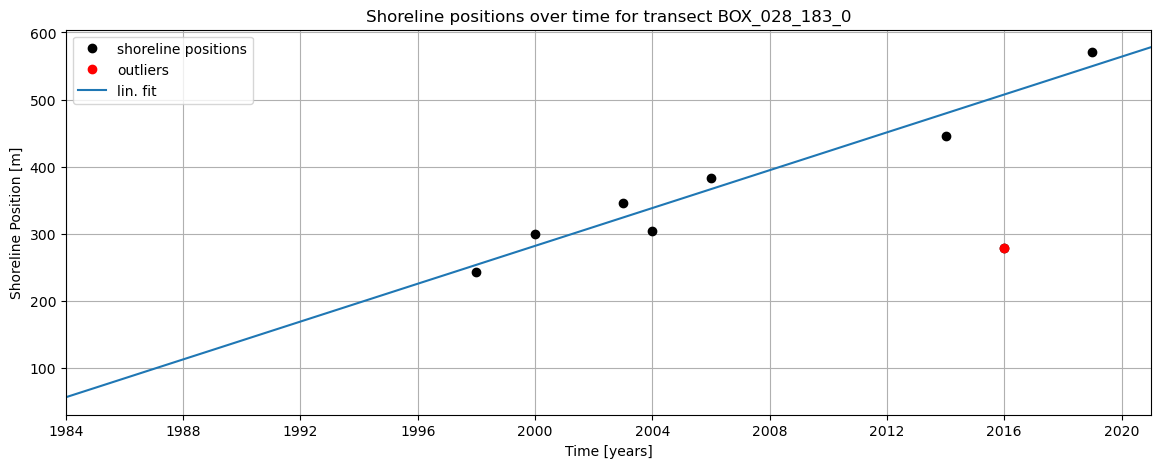

In [ ]:
station = 0  # select station
# TODO: color the outlier
# TODO: add more info to the plot (sandy, uncertainty etc)

time_inds = np.array([i for i in range(len(ds.time.values))])
cr = ds.isel(stations=station)["changerate"].values
cr_unc = ds.isel(stations=station)["intercept"].values

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ds.time, ds.isel(stations=station)["sp"].values, 'ko', label="shoreline positions")
outl_idx = [i for i,x in enumerate(ds.isel(stations= station)['outliers'].values) if x == 1]
outliers, outliers_time = ds.isel(stations=station)["sp"].values[outl_idx], ds.time[outl_idx]
ax.plot(outliers_time, outliers, 'ro', label="outliers")
ax.plot(ds.time, time_inds*cr + cr_unc, label="lin. fit")
ax.set_xlabel("Time [years]")
ax.set_ylabel("Shoreline Position [m]")
ax.set_title(
    "Shoreline positions over time for transect %s"%ds.isel(stations=station)["transect_id"].values.tolist().decode("utf-8") 
)
plt.grid()
plt.xlim(ds.time[0], ds.time[-1])
plt.legend();